In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

import re 
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [66]:
!pip install tensorflow

  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
   ---------------------------------------- 0.0/331.9 MB ? eta -:--:--
   ---------------------------------------- 1.0/331.9 MB 4.6 MB/s eta 0:01:13
   ---------------------------------------- 1.8/331.9 MB 3.9 MB/s eta 0:01:26
   ---------------------------------------- 2.4/331.9 MB 3.4 MB/s eta 0:01:39
   ---------------------------------------- 2.9/331.9 MB 3.4 MB/s eta 0:01:39
    --------------------------------------- 4.2/331.9 MB 3.8 MB/s eta 0:01:28
    --------------------------------------- 5.0/331.9 MB 3.8 MB/s eta 0:01:26
    --------------------------------------- 5.5/331.9 MB 3.7 MB/s eta 0:01:28
    --------------------------------------- 6.6/331.9 MB 3.8 MB/s eta 0:01:27
    --------------------------------------- 7.3/331.9 MB 3.7 MB/s eta 0:01:27
    --------------------------------------- 8.1/331.9 MB 3.7 MB/s eta 0:01:27
   - -------------------------------------- 8.9/331.9 MB 3.7 MB/s eta 0:01

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.33.5 which is incompatible.


In [2]:
df = pd.read_csv('badminton_data.csv')
df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [4]:
df.shape

(8518, 8)

In [5]:
df.columns

Index(['Reviewer Name', 'Review Title', 'Place of Review', 'Up Votes',
       'Down Votes', 'Month', 'Review text', 'Ratings'],
      dtype='object')

In [6]:
df.isnull().sum().sort_values(ascending=False)

Month              465
Place of Review     50
Reviewer Name       10
Review Title        10
Up Votes            10
Down Votes          10
Review text          8
Ratings              0
dtype: int64

In [7]:
df['Ratings'].value_counts().sort_index()

Ratings
1     769
2     308
3     615
4    1746
5    5080
Name: count, dtype: int64

In [8]:
def label_sentiment(rating):
    if rating >= 4:
        return "Positive"
    elif rating <= 2:
        return "Negative"
    else:
        return "Neutral"

In [9]:
label_sentiment(5)

'Positive'

In [10]:
df['Review_length'] = df['Review text'].astype(str).apply(len)

df[['Review_length']].describe()

,Review_length
count,8518.000000
mean,38.822963
std,42.765445
min,3.000000
25%,16.000000
50%,23.000000
75%,44.000000
max,509.000000


In [11]:
df = df.dropna(subset=['Review text']).copy()

In [12]:
df['Sentiment'] = df['Ratings'].apply(label_sentiment)

In [13]:
df['Sentiment'].value_counts()

Sentiment
Positive    6823
Negative    1072
Neutral      615
Name: count, dtype: int64

In [14]:
df.shape

(8510, 10)

In [15]:
df.columns

Index(['Reviewer Name', 'Review Title', 'Place of Review', 'Up Votes',
       'Down Votes', 'Month', 'Review text', 'Ratings', 'Review_length',
       'Sentiment'],
      dtype='object')

In [16]:
df = df[df['Sentiment']!= 'Neutral'].copy()

In [21]:
df['Sentiment'].value_counts()

Sentiment
Positive    6823
Negative    1072
Name: count, dtype: int64

In [22]:
df.shape

(7895, 10)

In [24]:
df = df.rename(columns={'Review text' : 'review_text'})

In [25]:
df.columns

Index(['Reviewer Name', 'Review Title', 'Place of Review', 'Up Votes',
       'Down Votes', 'Month', 'review_text', 'Ratings', 'Review_length',
       'Sentiment'],
      dtype='object')

In [30]:
df['review_text']

0       Nice product, good quality, but price is now r...
1       They didn't supplied Yonex Mavis 350. Outside ...
2       Worst product. Damaged shuttlecocks packed in ...
4       Over pricedJust â?¹620 ..from retailer.I didn'...
5       Good quality product. Delivered on time.READ MORE
                              ...                        
8504          Received product intact and sealedREAD MORE
8506    up to the mark but same is available in market...
8507                         Nice delivery speedREAD MORE
8508    No complaints about the item . Its the best on...
8509    Not sure why we have charged for this product ...
Name: review_text, Length: 7895, dtype: object

In [32]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [35]:
def clean_text(text):

    text = text.lower()
    text = re.sub(r'[^a-z\s]','',text)

    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return ' '.join(words)

In [36]:
df['clean_review'] = df['review_text'].apply(clean_text)

In [38]:
df[['review_text','clean_review']].head()

,review_text,clean_review
0,"Nice product, good quality, but price is now r...",nice product good quality price rising bad sig...
1,They didn't supplied Yonex Mavis 350. Outside ...,didnt supplied yonex mavis outside cover yonex...
2,Worst product. Damaged shuttlecocks packed in ...,worst product damaged shuttlecock packed new b...
4,Over pricedJust â?¹620 ..from retailer.I didn'...,pricedjust retaileri didnt understand wat adva...
5,Good quality product. Delivered on time.READ MORE,good quality product delivered timeread


In [39]:
(df['clean_review'].str.len() == 0).sum()

0

In [41]:
X = df['clean_review']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=0.2,
    random_state=42,
    stratify = y 
)

In [43]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [44]:
X_train_tfidf.shape

(6316, 5000)

In [45]:
X_test_tfidf.shape

(1579, 5000)

In [47]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')

In [48]:
log_reg.fit(X_train_tfidf,y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [49]:
y_pred = log_reg.predict(X_test_tfidf)

In [50]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    Negative       0.64      0.76      0.70       214
    Positive       0.96      0.93      0.95      1365

    accuracy                           0.91      1579
   macro avg       0.80      0.85      0.82      1579
weighted avg       0.92      0.91      0.91      1579



In [52]:
nb = MultinomialNB()

In [53]:
nb.fit(X_train_tfidf,y_train)

MultinomialNB()

In [55]:
y_pred_nb = nb.predict(X_test_tfidf)

In [56]:
print(classification_report(y_test,y_pred_nb))

              precision    recall  f1-score   support

    Negative       0.89      0.37      0.52       214
    Positive       0.91      0.99      0.95      1365

    accuracy                           0.91      1579
   macro avg       0.90      0.68      0.74      1579
weighted avg       0.91      0.91      0.89      1579



In [58]:
svm = LinearSVC(class_weight='balanced')

In [59]:
svm.fit(X_train_tfidf,y_train)

LinearSVC(class_weight='balanced')

In [60]:
y_pred_svm = svm.predict(X_test_tfidf)

In [61]:
print(classification_report(y_test,y_pred_svm))

              precision    recall  f1-score   support

    Negative       0.67      0.71      0.69       214
    Positive       0.95      0.94      0.95      1365

    accuracy                           0.91      1579
   macro avg       0.81      0.83      0.82      1579
weighted avg       0.92      0.91      0.91      1579



In [63]:
le = LabelEncoder()

In [64]:
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [73]:
ann = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

C:\Users\tnchi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [74]:
ann.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [75]:
ann.fit(
    X_train_tfidf.toarray(),
    y_train_encoded,
    epochs = 5,
    batch_size = 64,
    validation_split = 0.1,
    verbose=1
)

Epoch 1/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6840 - loss: 0.6876 - val_accuracy: 0.8718 - val_loss: 0.6753
Epoch 2/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8633 - loss: 0.6640 - val_accuracy: 0.8718 - val_loss: 0.6475
Epoch 3/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8633 - loss: 0.6291 - val_accuracy: 0.8718 - val_loss: 0.6025
Epoch 4/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8633 - loss: 0.5754 - val_accuracy: 0.8718 - val_loss: 0.5379
Epoch 5/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8633 - loss: 0.5065 - val_accuracy: 0.8718 - val_loss: 0.4665


In [78]:
y_pred_ann = (ann.predict(X_test_tfidf.toarray()) > 0.3).astype(int)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [79]:
print(classification_report(y_test_encoded, y_pred_ann, target_names = le.classes_))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       214
    Positive       0.86      1.00      0.93      1365

    accuracy                           0.86      1579
   macro avg       0.43      0.50      0.46      1579
weighted avg       0.75      0.86      0.80      1579



C:\Users\tnchi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tnchi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tnchi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [81]:
cm = confusion_matrix(y_test,y_pred)

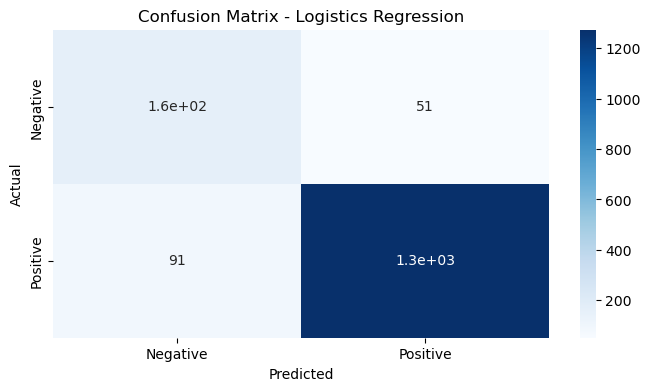

In [86]:
plt.figure(figsize=(8,4))
sns.heatmap(cm , annot=True, cmap='Blues',
           xticklabels=le.classes_,
           yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistics Regression')
plt.show()

In [88]:
feature_names = tfidf.get_feature_names_out()
coefficient = log_reg.coef_[0]

In [89]:
top_positive = sorted(
    zip(coefficient,feature_names),
    reverse=True
)[:15]

top_negative = sorted(
    zip(coefficient, feature_names)
)[:15]

In [90]:
print("Top Positive Words:")
for coef, word in top_positive:
    print(word)

print("\nTop Negative Words:")
for coef, word in top_negative:
    print(word)

Top Positive Words:
best
nice
good quality
excellent
super
great
niceread
awesome
awesomeread
superread
bestread
superb
superbread
perfect
good product

Top Negative Words:
bad
worst
poor
dont
quality
waste
worstread
old
badread
shuttle
damagedread
damaged
box
day
poorread


In [92]:
joblib.dump(log_reg,'sentiment_model.pkl')
joblib.dump(tfidf,'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']